<a href="https://colab.research.google.com/github/binruiyang/utils/blob/main/AML_HW6_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

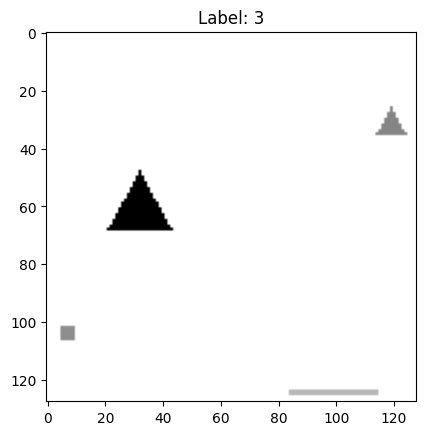

In [5]:
import os
import sys
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import random_shapes
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from skimage.draw import random_shapes
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

np.random.seed(123)
torch.manual_seed(123)

class ShapesDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = self.transform(image)

        return image, label

def generate_shapes_data(num_samples=1000, image_size=(128, 128)):
    images = []
    labels = []

    for _ in range(num_samples):
        image, label = random_shapes(image_size, max_shapes=4, min_shapes=1, allow_overlap=True)
        image = image[:, :, 0]
        image = (image / 255.0).astype(np.float32)
        label = len(label)
        labels.append(label - 1)
        images.append(image)

    return np.array(images), np.array(labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images, labels = generate_shapes_data()
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 32
train_dataset = ShapesDataset(train_images, train_labels, transform=transform)
test_dataset = ShapesDataset(test_images, test_labels, transform=transform)
shapes_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
shapes_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
example_image, example_label = train_dataset[0]
plt.imshow(example_image.squeeze(), cmap='gray')
plt.title(f"Label: {example_label}")
plt.show()

# CLIP: Connecting Text and Images

CLIP (Contrastive Language–Image Pre-training) is a neural network developed by OpenAI that bridges the gap between visual concepts and natural language descriptions. It is trained on a diverse dataset of image-text pairs from the internet, enabling it to perform a variety of visual classification tasks without requiring task-specific fine-tuning.

## Key Features
1. **Zero-Shot Learning**: CLIP can classify images based on natural language prompts without being explicitly trained for specific benchmarks.
2. **Generalization**: Unlike traditional vision models that require labeled datasets, CLIP learns directly from image-text pairs, improving its robustness and flexibility.
3. **Wide Applicability**: CLIP is capable of zero-shot transfer across numerous datasets, making it highly adaptable for diverse visual recognition tasks.

## Applications
- Classifying images with text prompts.
- Exploring relationships between images and captions.
- Enabling multi-modal tasks that combine vision and language understanding.

CLIP represents a step forward in creating models that generalize better across tasks by leveraging the relationship between visual and linguistic data. (You can read more about this network [here](https://openai.com/blog/clip/)).

# Exploring CNN and CLIP: Image Classification and Multi-Modal Predictions

## Problem Description
In this assignment, you will:

0. Generate synthetic images including random number of objects (ROB).

$\textit{Please keep the number of objects in the image set between 1 and 4 with image size 128 x 128 in grayscale with object overlap}$

$\textit{However, you may modify the data in any other way you see fit (i.e. preprocessing, batch size, etc.)}$

1. Train a Convolutional Neural Network (CNN) on the MNIST and RandOb datasets.
2. Experiment with CLIP to classify images of "apple" in various settings.
3. Compare the performance of MNIST and ROB CNN and CLIP.


---

## Tasks

### Task 1: Train a CNN on MNIST and ROB
- Build and train a CNN with **at least 3 convolutional layers** to classify MNIST digits (0-9).
- Show the training and testing loss curves (overlaid on one plot) for a reasonable number of epochs.
- Evaluate its accuracy on the test set.


- Build and train a CNN with **at least 3 convolutional layers** to classify ROB images (1-4).
- Show the training and testing loss curves (overlaid on one plot) for a reasonable number of epochs.
- Evaluate its accuracy on the test set.

Please make sure that your models are training properly with the loss curves, but do not spend too much time
optimizing your test accuracy. We are looking for sound methodology and are not grading based on your ability to achieve the highest possible accuracy.

You may use the same general architecture for both problems.

---

### Task 2: Experiment with CLIP
1. **Setup**:
   - Download and initialize the pre-trained CLIP model.
   - https://github.com/openai/CLIP
2. **Image Testing**:
   - Prepare images of:
     - An apple.
   - Test this in:
     - **Simple Background**: No other objects.
     - **Messy Background**: Cluttered with unrelated objects.
   - Use CLIP to classify each image as "apple" and record predictions.

---

### Task 3: Compare CNN and CLIP: MNIST
- Compare the CNN’s performance on MNIST with CLIP.
- Discuss the strengths and weaknesses of task-specific models (CNN) vs. general models (CLIP).
- Talk about the differences in datasets. Why is MNIST easier than ROB?

---

### Task 4: Compare CNN and CLIP: ROB
1. Generate synthetic images with **1 to 4 objects** per image.
2. Define possible labels (there should be four labels total):
   - "Number of objects is one."
   - "Number of objects is two."
   - ...
   - "Number of objects is four."
3. Use CLIP to predict the number of objects in each image and analyze its performance.

---

## Deliverables
1. **CNN Training**:
   - Code, training curves, test accuracy on MNIST.
2. **CLIP Testing**:
   - Predictions for "apple" in both simple and messy backgrounds.
3. **Comparison**:
   - Analysis of CNN vs. CLIP performance.
4. **Object Count Testing**:
   - Synthetic images, predictions, and analysis of CLIP’s ability to handle object counting.

---

### Notes
- Use PyTorch for the CNN and CLIP.
- Ensure image preprocessing matches model requirements.

### Task 1: Train a CNN on MNIST and ROB
- Build and train a CNN with **at least 3 convolutional layers** to classify MNIST digits (0-9).
- Show the training and testing loss curves (overlaid on one plot) for a reasonable number of epochs.
- Evaluate its accuracy on the test set.


- Build and train a CNN with **at least 3 convolutional layers** to classify ROB images (1-4).
- Show the training and testing loss curves (overlaid on one plot) for a reasonable number of epochs.
- Evaluate its accuracy on the test set.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        x = self.fc(x)
        return x

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Testing phase
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        accuracy = 100. * correct / total

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Test Loss: {test_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.2f}%')
        print('--------------------')

    return train_losses, test_losses

In [7]:
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform_mnist)
mnist_test = datasets.MNIST('./data', train=False, transform=transform_mnist)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10

mnist_model = CNN(num_classes=10).to(device)
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)

mnist_train_losses, mnist_test_losses = train_model(
    mnist_model, mnist_train_loader, mnist_test_loader,
    mnist_criterion, mnist_optimizer, num_epochs, device
)

rob_model = CNN(num_classes=4).to(device)
rob_criterion = nn.CrossEntropyLoss()
rob_optimizer = optim.Adam(rob_model.parameters(), lr=0.001)

rob_train_losses, rob_test_losses = train_model(
    rob_model, shapes_train_loader, shapes_test_loader,
    rob_criterion, rob_optimizer, num_epochs, device
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.40MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10:
Train Loss: 0.1186
Test Loss: 0.0302
Test Accuracy: 99.03%
--------------------
Epoch 2/10:
Train Loss: 0.0548
Test Loss: 0.0331
Test Accuracy: 99.13%
--------------------
Epoch 3/10:
Train Loss: 0.0436
Test Loss: 0.0343
Test Accuracy: 99.03%
--------------------
Epoch 4/10:
Train Loss: 0.0400
Test Loss: 0.0262
Test Accuracy: 99.22%
--------------------
Epoch 5/10:
Train Loss: 0.0341
Test Loss: 0.0244
Test Accuracy: 99.35%
--------------------
Epoch 6/10:
Train Loss: 0.0302
Test Loss: 0.0302
Test Accuracy: 99.39%
--------------------
Epoch 7/10:
Train Loss: 0.0308
Test Loss: 0.0396
Test Accuracy: 99.07%
--------------------
Epoch 8/10:
Train Loss: 0.0255
Test Loss: 0.0343
Test Accuracy: 99.14%
--------------------
Epoch 9/10:
Train Loss: 0.0230
Test Loss: 0.0342
Test Accuracy: 99.21%
--------------------
Epoch 10/10:
Train Loss: 0.0216
Test Loss: 0.0393
Test Accuracy: 99.16%
--------------------
Epoc

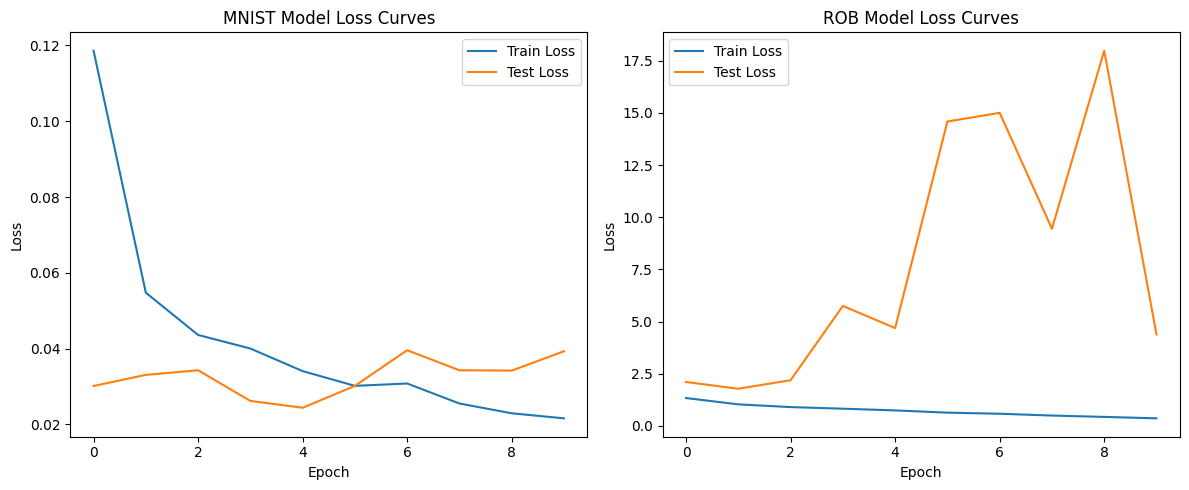

In [8]:

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(mnist_train_losses, label='Train Loss')
plt.plot(mnist_test_losses, label='Test Loss')
plt.title('MNIST Model Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rob_train_losses, label='Train Loss')
plt.plot(rob_test_losses, label='Test Loss')
plt.title('ROB Model Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Task 2: Experiment with CLIP

In [9]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ur3399vu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ur3399vu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=9d16c8bf526391b8c56cbaaf1cdaaedbf2cdea01f1c78960c3dc542962afb2ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-o3isuqaz/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [10]:
import torch
import clip
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def prepare_image(image):
    return preprocess(image).unsqueeze(0).to(device)

def classify_image(image, text_inputs):
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_inputs)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        return similarity.cpu().numpy()[0]

def display_results(image, probabilities, categories):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')


    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(categories))
    plt.barh(y_pos, probabilities)
    plt.yticks(y_pos, [cat.replace("a photo of ", "") for cat in categories])
    plt.xlabel('Probability')
    plt.title('CLIP Predictions')

    plt.tight_layout()
    plt.show()


Processing Simple Apple...

Results for Simple Apple:
an apple: 98.68%
an orange: 1.30%


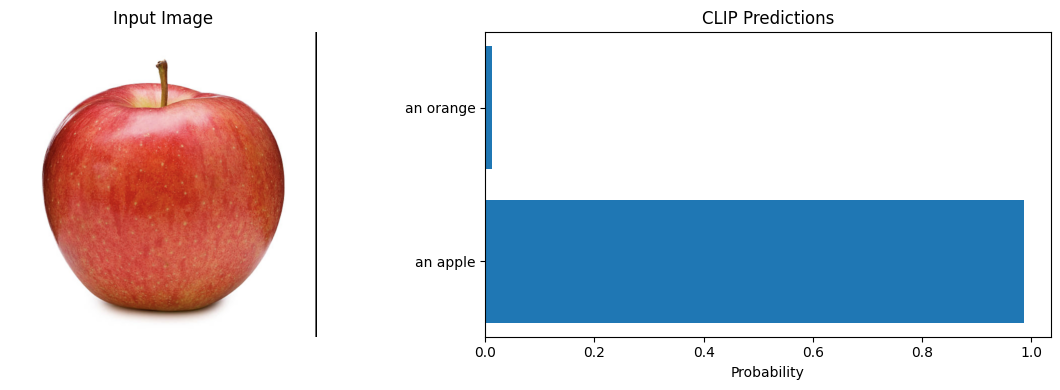


Processing Messy Apple...

Results for Messy Apple:
an apple: 99.51%
an orange: 0.48%


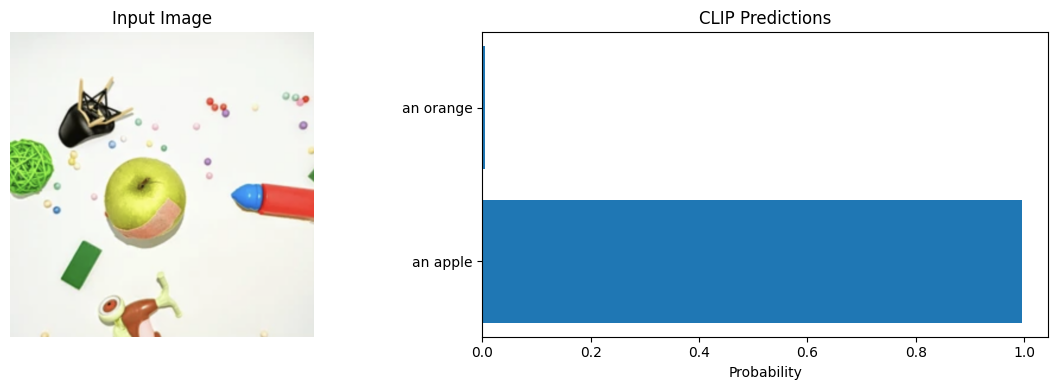

Simple Apple: Apple probability = 98.68%
Messy Apple: Apple probability = 99.51%


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


categories = [
    "an apple",
    "an orange"
]
text_inputs = clip.tokenize(categories).to(device)

test_images = {
    "Simple Apple": "apple.jpg",
    "Messy Apple": "messy_apple.jpg"
}

results = {}
for image_name, image_path in test_images.items():
    print(f"\nProcessing {image_name}...")

    image = Image.open(image_path)
    processed_image = prepare_image(image)
    probs = classify_image(processed_image, text_inputs)
    results[image_name] = probs

    print(f"\nResults for {image_name}:")
    for category, prob in zip(categories, probs):
        print(f"{category}: {prob:.2%}")

    display_results(image, probs, categories)

for image_name, probs in results.items():
    apple_prob = probs[0]
    print(f"{image_name}: Apple probability = {apple_prob:.2%}")


### Task 3: Compare CNN and CLIP: MNIST
Compare the CNN’s performance on MNIST with CLIP.

 - CNN has a better classification result compared to CLIP because CNN is optimized for digit recognition whereas CLIP relies on natural language descriptions of digits.

Discuss the strengths and weaknesses of task-specific models (CNN) vs. general models (CLIP).

- CNNs are good at specific applications like digit recognition or object classification, but they are limited by their inability to adapt to new tasks without extensive retraining.

- CLIP has more flexibility by understanding a wide range of visual concepts through natural language descriptions though this flexibility comes at the cost of performance and higher computational requirements.

Talk about the differences in datasets. Why is MNIST easier than ROB?

- For MNIST, each image contains exactly one centered digit against a clean black background, with consistent sizing and orientation, making the input data more standardized and predictable. ROB images contain varying numbers of objects that can overlap and interact with each other, creating complex relationships that must be understood by the model.

### Task 4: Compare CNN and CLIP: ROB

In [14]:
images, labels = generate_shapes_data(num_samples=400)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)
text_descriptions = [
    "Number of objects is one.",
    "Number of objects is two.",
    "Number of objects is three.",
    "Number of objects is four."
]
text_inputs = clip.tokenize(text_descriptions).to(device)

In [15]:
def prepare_image_for_clip(image_array):

    image_rgb = np.stack([image_array] * 3, axis=-1)
    image_pil = Image.fromarray((image_rgb * 255).astype(np.uint8))
    return preprocess(image_pil).unsqueeze(0).to(device)



predictions = []
confidences = []
true_counts = []

for i in tqdm(range(len(images))):
    image = images[i]
    true_count = labels[i] + 1
    processed_image = prepare_image_for_clip(image)


    with torch.no_grad():
        image_features = model.encode_image(processed_image)
        text_features = model.encode_text(text_inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        pred_idx = similarity.argmax().item()
        pred_count = pred_idx + 1
        confidence = similarity[0][pred_idx].item()

        predictions.append(pred_count)
        confidences.append(confidence)
        true_counts.append(true_count)

accuracy = np.mean(np.array(predictions) == np.array(true_counts))
print(f"\nOverall Accuracy: {accuracy:.2%}")


100%|██████████| 400/400 [00:08<00:00, 48.67it/s]


Overall Accuracy: 31.00%


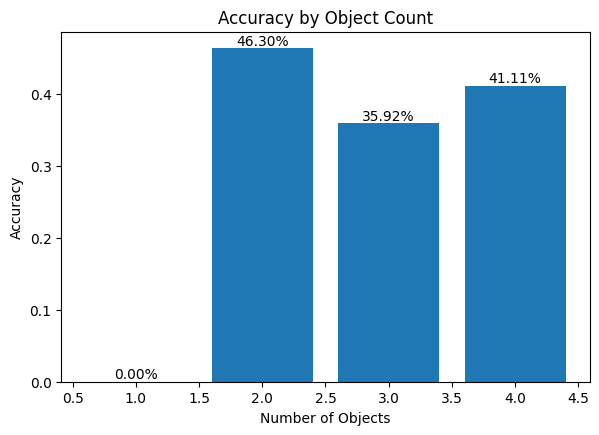

In [19]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
accuracies_by_count = []
for count in range(1, 5):
    mask = np.array(true_counts) == count
    acc = np.mean(np.array(predictions)[mask] == count)
    accuracies_by_count.append(acc)

plt.bar(range(1, 5), accuracies_by_count)
plt.title('Accuracy by Object Count')
plt.xlabel('Number of Objects')
plt.ylabel('Accuracy')
for i, acc in enumerate(accuracies_by_count):
    plt.text(i+1, acc, f'{acc:.2%}', ha='center', va='bottom')

In [20]:
correct_predictions = np.array(predictions) == np.array(true_counts)
print("\nConfidence Analysis:")
print(f"Average confidence for correct predictions: {np.mean(np.array(confidences)[correct_predictions]):.2%}")
print(f"Average confidence for incorrect predictions: {np.mean(np.array(confidences)[~correct_predictions]):.2%}")


Confidence Analysis:
Average confidence for correct predictions: 30.44%
Average confidence for incorrect predictions: 29.82%
